# **Chroma1-HD for Text to Image Generation**
- Project page: https://huggingface.co/lodestones/Chroma1-HD
- Notebook source: https://github.com/Isi-dev/Google-Colab_Notebooks
- Premium notebooks I highly recommend: https://isinse.gumroad.com/
- Even $1 helps support my work: https://buymeacoffee.com/isiomo


In [ ]:
# @markdown # 💥1. Setup Environment
# !pip install --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu124
# !pip install --upgrade --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install torch==2.8.0 torchvision==0.23.0
%cd /content

from IPython.display import clear_output
!git clone --branch ComfyUI_v0.3.65 https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
# !git clone https://github.com/Isi-dev/ComfyUI_Img2PaintingAssistant
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
# !git clone https://github.com/Isi-dev/ComfyUI_KJNodes.git
# clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
# %cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
# !pip install -r requirements.txt
# clear_output()
%cd /content/ComfyUI

import subprocess
import sys

def install_pip_packages():
    packages = [
        'torchsde',
        'av',
        'diffusers',
        # 'transformers',
        'xformers==0.0.32.post1',
        'accelerate',
        # 'omegaconf',
        # 'tqdm',
        # 'librosa',
        'einops',
        'spandrel'
    ]

    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")


print("Installing pip packages...")
install_pip_packages()
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")

import torch
import numpy as np
from PIL import Image
import gc
import os
import torch
from PIL import Image
import random
import imageio
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from nodes import (
    UNETLoader,
    DualCLIPLoader,
    CLIPLoader,
    CLIPTextEncode,
    VAEEncode,
    VAEEncodeForInpaint,
    VAEDecode,
    VAELoader,
    KSampler,
    ConditioningZeroOut,
    InpaintModelConditioning,
    ImageScaleBy,
    ImageScale,
    LoraLoaderModelOnly,
    LoadImage,
    SaveImage
)

# from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from comfy_extras.nodes_model_advanced import ModelSamplingSD3

from comfy_extras.nodes_sd3 import EmptySD3LatentImage



from pathlib import Path



def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename


def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)

chroma_HD_Model = "https://huggingface.co/silveroxides/Chroma1-HD-fp8-scaled/resolve/main/Chroma1-HD-fp8_scaled_rev2.safetensors" # @param {"type":"string"}
t5xxl_model ="https://huggingface.co/silveroxides/t5xxl_flan_enc/resolve/main/t5xxl_flan_new_alt_fp8_e4m3fn_scaled.safetensors" # @param {"type":"string"}
chroma_vae = "https://huggingface.co/lodestones/Chroma1-HD/resolve/main/vae/diffusion_pytorch_model.safetensors" # @param {"type":"string"}

lora = None
download_loRA = True # @param {type:"boolean"}
chroma_HD_lora_url = "https://civitai.com/api/download/models/2335540?type=Model&format=SafeTensor" # @param {"type":"string"}
token_if_civitai_url = "" # @param {"type":"string"}
if download_loRA:
    lora = download_lora(chroma_HD_lora_url, civitai_token=token_if_civitai_url)
# Validate loRA file extension
valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
if lora:
    if not any(lora.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora}")
        lora = None
    else:
        clear_output()
        print("loRA downloaded succesfully!")

def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False




chroma_model = model_download(chroma_HD_Model, "/content/ComfyUI/models/unet")
flux_vae = model_download(chroma_vae, "/content/ComfyUI/models/vae")
t5xxl = model_download(t5xxl_model , "/content/ComfyUI/models/clip")



# clip_loader = DualCLIPLoader()
clip_loader = CLIPLoader()
# unet_loader =  UnetLoaderGGUF()
unet_loader =  UNETLoader()
vae_loader =   VAELoader()
vae_encode = VAEEncode()
vae_decode = VAEDecode()
ksampler = KSampler()
load_lora = LoraLoaderModelOnly()
load_turbo_lora = LoraLoaderModelOnly()
model_sampling = ModelSamplingSD3()
save_image = SaveImage()
positive_prompt_encode = CLIPTextEncode()
negative_prompt_encode = CLIPTextEncode()

empty_latent_image = EmptySD3LatentImage()


def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()


def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path




import cv2
import shutil
import datetime


def generate_image(
    positive_prompt: str = "",
    negative_prompt: str = "",
    guidance: float = 2.5,
    width: int = 832,
    height: int = 480,
    seed: int = 0,
    steps: int = 20,
    cfg: float = 1.0,
    shift: float = 1.0,
    sampler_name: str = "euler",
    scheduler: str = "simple",
    denoise: float = 1.0,
    use_turbo_lora: bool = False,
    LoRA_Strength: float = 1.0,
    overwrite: bool = False

):

    with torch.inference_mode():

        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip(t5xxl, "chroma")[0]


        positive = positive_prompt_encode.encode(clip, positive_prompt)[0]

        negative = negative_prompt_encode.encode(clip, negative_prompt)[0]


        del clip
        torch.cuda.empty_cache()
        gc.collect()

        try:
            print("Loading Unet Model...")
            model = unet_loader.load_unet(chroma_model, "default")[0]
            # model = model_sampling.patch(model, shift)[0]

            if use_turbo_lora and lora is not None:
                print("Loading Lora...")
                model = load_turbo_lora.load_lora_model_only(model, lora, LoRA_Strength)[0]


            latent = empty_latent_image.generate(width, height, 1)[0]

            clear_output()

            print("Generating Image...")
            image_out_latent = ksampler.sample(
                model=model,
                seed=seed,
                steps=steps,
                cfg=cfg,
                sampler_name=sampler_name,
                scheduler=scheduler,
                positive=positive,
                negative=negative,
                latent_image=latent,
                denoise=1
            )[0]

            del model
            torch.cuda.empty_cache()
            gc.collect()

            print("Loading VAE...")
            vae = vae_loader.load_vae(flux_vae)[0]

            print("Decoding latents...")
            decoded = vae_decode.decode(vae, image_out_latent)[0]

            del vae
            torch.cuda.empty_cache()
            gc.collect()

            base_name = "ComfyUI"
            if not overwrite:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_name += f"_{timestamp}"

            outputImagePath = save_as_image(decoded[0], base_name)
            display(IPImage(filename=outputImagePath))

        except Exception as e:
            print(f"Error during Image Generation/saving: {str(e)}")
            raise
        finally:
            clear_memory()

clear_output()


print("✅ Environment Setup Complete!")



Generating Image...


  0%|          | 0/26 [00:00<?, ?it/s]

Loading VAE...
Decoding latents...


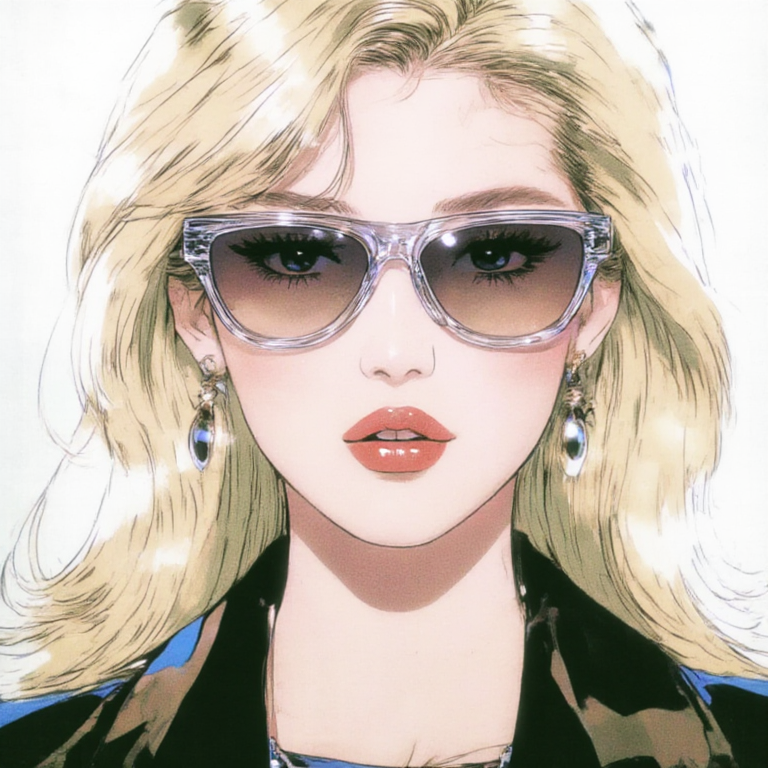

In [2]:
# @markdown # 💥4. Generate Image

positive_prompt="A high-fashion close-up portrait of a blonde woman in clear sunglasses. The photo is sharp and well-composed. It looks professionally done. Anime style." # @param {"type":"string"}
negative_prompt="low quality, ugly, unfinished, out of focus, deformed, disfigure, blurry, smudged, restricted palette, flat colors" # @param {"type":"string"}
guidance=2.5

width = 768 # @param {"type":"number"}
height = 768 # @param {"type":"number"}

overwrite_previous_output=False # @param {type:"boolean"}
# @markdown ---
# @markdown ### Sampler Settings
seed=0 # @param {"type":"integer"}
steps = 26 # @param {"type":"slider","min":0,"max":100,"step":1}
cfg = 3.8 # @param {"type":"slider","min":0,"max":20,"step":0.1}
shift = 1.0
sampler_name="euler" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler="simple" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
denoise=1
# @markdown ---
# @markdown ### LoRA Settings
# use_turbo_lora=False # @param {type:"boolean"}
use_lora=True # @param {type:"boolean"}
LoRA_Strength=1 # @param {"type":"slider","min":-1,"max":1,"step":0.01}


import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")



generate_image(
    positive_prompt = positive_prompt,
    negative_prompt = negative_prompt,
    guidance = guidance,
    width=width,
    height=height,
    seed = seed,
    steps = steps,
    cfg = cfg,
    shift=shift,
    sampler_name = sampler_name,
    scheduler = scheduler,
    denoise = denoise,
    use_turbo_lora = use_lora,
    LoRA_Strength = LoRA_Strength,
    overwrite = overwrite_previous_output
)

clear_memory()